# 0. System Check

In [1]:
!nvidia-smi

Wed Mar  6 22:30:54 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.108.03   Driver Version: 510.108.03   CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   32C    P0    22W / 250W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  Off  | 00000000:D8:00.0 Off |                    0 |
| N/A   

# 1. Module

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib 

import os, logging
from tqdm import tqdm
import time
from helpers import get_ip_address, has_write_permission, measure_performance, save_preprocessed_data, read_preprocessed_data

import warnings
# 경고 메시지 무시
warnings.filterwarnings("ignore")

# 2. Data Load_Y

In [2]:
data_locations = {
    '223.195.111.48': '/project/datacamp/team11/data',
    '147.47.44.229': '/home/jinhyun/data/1kGP',
}

chr_list = [str(x) for x in range(1,23)]
gt_dict = {"0|0" :0, "0|1" : 1, "1|0" : 2, "1|1" : 3 } # genotype dict for converting string-> inteter 

In [3]:
raw_data_path = data_locations.get(get_ip_address(), '/not_found')
sample_annotation_file = os.path.join(raw_data_path, "igsr-1000 genomes 30x on grch38.tsv")
preprocess_path = os.path.join(raw_data_path, "preprocessed")

assert os.path.exists(preprocess_path), f"Data path not exists: {raw_data_path} OR IP setting is incorrect: {get_ip_address()}"
assert os.path.isfile(sample_annotation_file), f"File not exists : {sample_annotation_file}"
assert has_write_permission(preprocess_path), f"You do not have write permission for {preprocess_path}"

In [4]:
sample_annotation_df = pd.read_csv(sample_annotation_file, sep="\t")
print(f"Read sample annotation info with shape : {sample_annotation_df.shape}")

Read sample annotation info with shape : (3202, 9)


## Population code

In [5]:
remove_row = sample_annotation_df[sample_annotation_df['Population code'] == 'IBS,MSL']
print(remove_row.index)

New_sample_annotation_df_ = sample_annotation_df.drop(remove_row.index)


# print(New_sample_annotation_df_)
New_sample_annotation_df_.value_counts('Population code')

continent = New_sample_annotation_df_['Population code']
continent

Index([2192], dtype='int64')


0       FIN
1       FIN
2       FIN
3       FIN
4       FIN
       ... 
3197    GIH
3198    GIH
3199    GIH
3200    GIH
3201    CEU
Name: Population code, Length: 3201, dtype: object

# 3. Data_Load_X

In [6]:
npy_path = os.path.join(preprocess_path, 'merged_support3_variance_0.1_matrix.npy')
data = np.load(npy_path)

X = data
y = continent

## Data of Population_name

In [7]:
X = np.delete(X, 2192, axis=0)
print(X)
print(X.shape)

[[0 1 1 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 2 2 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 1 ... 0 0 0]]
(3201, 5105448)


## Data Check

In [8]:
print(X)
print(X.shape)
print(y)
print(y.shape)

[[0 1 1 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 2 2 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 1 ... 0 0 0]]
(3201, 5105448)
0       FIN
1       FIN
2       FIN
3       FIN
4       FIN
       ... 
3197    GIH
3198    GIH
3199    GIH
3200    GIH
3201    CEU
Name: Population code, Length: 3201, dtype: object
(3201,)


## Data_Split

In [9]:
# 데이터를 훈련 세트와 테스트 세트로 분할
random_seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)


In [10]:
print(X_train.shape)
print(X_test.shape)
print(y_train)
print(y_test)

(2560, 5105448)
(641, 5105448)
561     MSL
282     IBS
1465    PUR
1576    IBS
807     ITU
       ... 
1095    YRI
1130    MXL
1294    GIH
860     STU
3175    ASW
Name: Population code, Length: 2560, dtype: object
1374    FIN
1195    MXL
2938    STU
1506    PUR
214     CLM
       ... 
43      CHS
87      FIN
1812    IBS
2939    TSI
2479    YRI
Name: Population code, Length: 641, dtype: object


# 4. Modeling

## 4.1 SVM

In [11]:
# from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score
# import time

# svm_model = SVC()
# param_grid = {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1], 'kernel': ['linear', 'rbf']}
# grid_search = GridSearchCV(svm_model, param_grid, cv=2, n_jobs=-1, verbose=2)

# grid_search.fit(X_train, y_train)
# print("Best Parameters: ", grid_search.best_params_)
# best_svm_model = grid_search.best_estimator_
# best_svm_model_params = grid_search.best_params_
# y_pred = best_svm_model.predict(X_test)

### 4.1.1 1M SVM(Previous parameters)

In [12]:
@measure_performance
def do_svm_train(X_train, y_train, X_test):
    previous_best_params = {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'} 
    svm_model = SVC(**previous_best_params)
    svm_model.fit(X_train, y_train)

    y_pred = svm_model.predict(X_test)
    return y_pred


In [13]:
y_pred = do_svm_train(X_train, y_train, X_test)

Function: do_svm_train
CPU Time: 0.7246 minutes
Physical Time: 0.7256 minutes
Memory Usage: 0.5178 GiB


In [11]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from IPython.display import clear_output

@measure_performance
def do_sgd_train(X_train, y_train, X_test, batch_size=1000, num_epoch = 5):
    random_seed = 12345
    np.random.seed(random_seed)

    sgd_model = SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, learning_rate='optimal', max_iter=1, tol=None, warm_start=True)
    #sgd_model = SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, learning_rate='optimal', max_iter=1000, tol=1e-3)

    classes = np.unique(y_train)

    n_batches = int(np.ceil(X_train.shape[0] / batch_size))

    accuracies = []
    plt.ion() # Turn on the interactive mode
    for epoch in range(num_epoch): #tqdm(range(num_epoch))
        X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state = epoch + random_seed)

        for batch in range(n_batches):
            start_idx = batch * batch_size
            end_idx = min((batch + 1) * batch_size, X_train.shape[0])

            X_batch = X_train_shuffled[start_idx:end_idx]
            y_batch = y_train_shuffled[start_idx:end_idx]

            sgd_model.partial_fit(X_batch, y_batch, classes=classes)

        # evaluate and draw figure
        accuracy = accuracy_score(y_test, sgd_model.predict(X_test))
        accuracies.append(accuracy)
        
        clear_output(wait=True)
        plt.figure(figsize=(6, 4))
        plt.plot(range(1, epoch + 2), accuracies, marker='o', linestyle='-', color='blue')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.grid(True)
        plt.xticks(range(1, epoch + 1))
        plt.show()

    plt.ioff() # Turn off the interactive mode
    y_pred = sgd_model.predict(X_test)
    return y_pred, accuracies

@measure_performance
def do_sgd_train_with_grid_search(X_train, y_train, X_test):

    param_grid = {
        'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1],
        'loss': ['hinge', 'log'],  # 'hinge' gives a linear SVM, 'log' gives logistic regression
        # Add more parameters here as needed
    }

    sgd_model = SGDClassifier(learning_rate='optimal', max_iter=1000, tol=1e-3)

    grid_search = GridSearchCV(estimator=sgd_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    print("Best parameters found:", best_params)

    y_pred = best_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy of the best model:", accuracy)

    return y_pred, best_params
    

In [20]:
#y_pred, best_params = do_sgd_train_with_grid_search(X_train, y_train, X_test)

Best parameters found: {'alpha': 0.0001, 'loss': 'hinge'}
Accuracy of the best model: 0.7207488299531981
Function: do_sgd_train_with_grid_search
CPU Time: 0.2312 minutes
Physical Time: 0.7921 minutes
Memory Usage: 0.4678 GiB


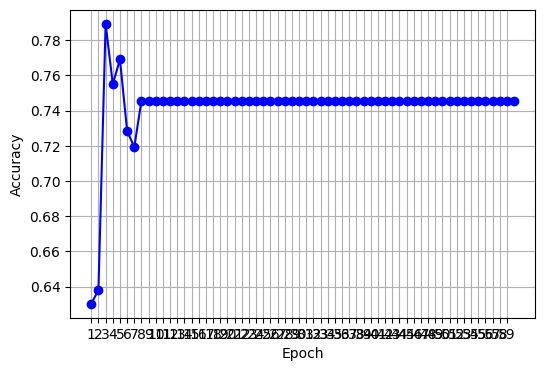

In [12]:
y_pred, accuracies = do_sgd_train(X_train, y_train, X_test,
                      batch_size = 100, num_epoch = 1000)


## 4.2 Parameter load

### 4.2.1 merged_random_100_matrix

In [ ]:
joblib.dump(best_svm_model, 'best_svm_model100.joblib')

with open('best_params100.txt', 'w') as f:
    f.write(str(grid_search.best_params_))
#######################################################
loaded_model = joblib.load('best_svm_model100.joblib')

with open('best_params100.txt', 'r') as f:
    loaded_params = eval(f.read())

y_pred = loaded_model.predict(X_test)

### 4.2.2 merged_random_1k_matrix

In [ ]:
joblib.dump(best_svm_model, 'best_svm_model1k.joblib')

with open('best_params1k.txt', 'w') as f:
    f.write(str(grid_search.best_params_))
#######################################################
loaded_model = joblib.load('best_svm_model1k.joblib')

with open('best_params1k.txt', 'r') as f:
    loaded_params = eval(f.read())

y_pred = loaded_model.predict(X_test)

### 4.2.3 merged_random_10k_matrix

In [ ]:
joblib.dump(best_svm_model, 'best_svm_model10k.joblib')

with open('best_params10k.txt', 'w') as f:
    f.write(str(grid_search.best_params_))
#######################################################
loaded_model = joblib.load('best_svm_model10k.joblib')

with open('best_params10k.txt', 'r') as f:
    loaded_params = eval(f.read())

y_pred = loaded_model.predict(X_test)

### 4.2.4 merged_random_100k_matrix

In [ ]:
joblib.dump(best_svm_model, 'best_svm_model100k.joblib')

with open('best_params100k.txt', 'w') as f:
    f.write(str(grid_search.best_params_))
#######################################################
loaded_model = joblib.load('best_svm_model100k.joblib')

with open('best_params100k.txt', 'r') as f:
    loaded_params = eval(f.read())

y_pred = loaded_model.predict(X_test)

### 4.2.5 merged_random_1M_matrix

In [ ]:
joblib.dump(best_svm_model, 'best_svm_model1M.joblib')

with open('best_params1M.txt', 'w') as f:
    f.write(str(grid_search.best_params_))
#######################################################
loaded_model = joblib.load('best_svm_model1M.joblib')

with open('best_params1M.txt', 'r') as f:
    loaded_params = eval(f.read())

y_pred = loaded_model.predict(X_test)

### 4.2.6 merged_random_zerofilter_0.005_matrix

In [ ]:
joblib.dump(best_svm_model, 'best_svm_model_zerofilter_0.0005.joblib')

with open('best_params_zerofilter_0.0005.txt', 'w') as f:
    f.write(str(grid_search.best_params_))
#######################################################
loaded_model = joblib.load('best_svm_model_zerofilter_0.0005.joblib')

with open('best_params_zerofilter_0.0005.txt', 'r') as f:
    loaded_params = eval(f.read())

y_pred = loaded_model.predict(X_test)

### y_test, y_pred

In [ ]:
# print(y_test)
# print(y_pred)

# 5 Quality_evaluation metrics

## 5.1 Accuracy

In [36]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}' )

Accuracy: 0.719188767550702


## 5.2 F1-score

In [37]:
f1_mi = f1_score(y_test, y_pred, average='micro')
f1_ma = f1_score(y_test, y_pred, average='macro')
f1_w = f1_score(y_test, y_pred, average='weighted')

print(f"micro: {f1_mi:.4f}; macro: {f1_ma:.4f}; weighted: {f1_w:.4f}")

micro: 0.7192; macro: 0.6956; weighted: 0.7263


## 5.3 Confusion matrix

Confusion Matrix:
[[17  4  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 5 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  0  0  0
   0  0]
 [ 0  0 15  0  0  0  0  0  0  0  0  0  0  0  2  1  0  0  0  0  0  2  0  0
   0  0]
 [ 0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  1  2  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0 38  0  0  2  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   2  0]
 [ 0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  1  0  5 24  0  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  0  0  0 23  0  0  0  0  0  0  0  0  0  0  0  0  1  0  1  0
   0  0]
 [ 5  1  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 0  0  0  0  3  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [ 3  0  0  0  8  0  0  3  0  1  1  0  0  0  0  0  0  0  0  0  0  0  1  0
   1  0]
 [ 1  0  1  0  0  0  0  0  0  0  0 10  0  0  6  0  0  0  0  0  0  4  

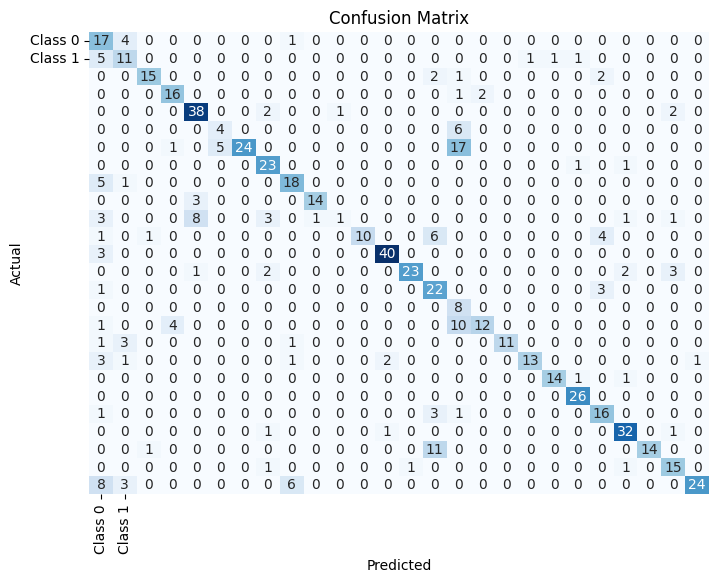

In [38]:
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()